In [1]:
# import generic packages
import numpy as np
from matplotlib import pyplot as plt

# import geospatial packages
import rasterio
from rasterio.plot import show
from shapely.geometry import LineString
import geopandas as gpd

# import landlab components
from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import OverlandFlow
from landlab.components.overland_flow import KinwaveImplicitOverlandFlow

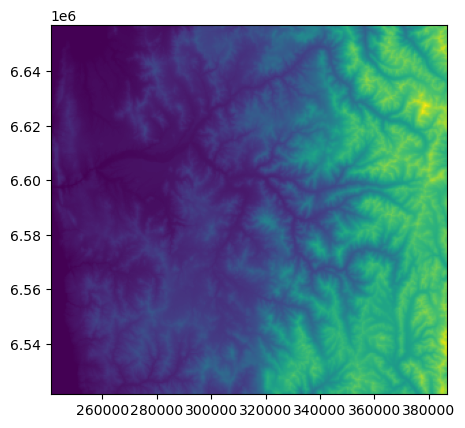

<Axes: >

In [4]:
# Open raster image 
rasterObj = rasterio.open('../Rst/DEMLimari500.tif')
show(rasterObj)

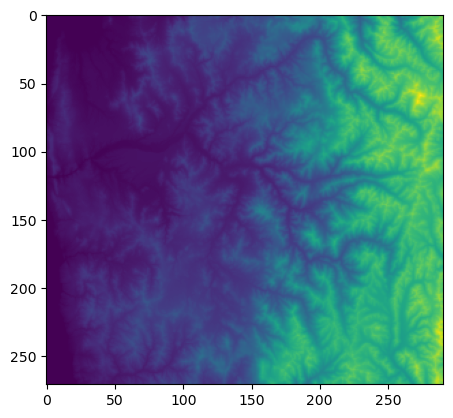

In [5]:
#extract array from raster
elevArray = rasterObj.read(1)
plt.imshow(elevArray)

In [6]:
#create grid from raster attributes
nrows = rasterObj.height  # number of raster cells on each side, initially 150
ncols = rasterObj.width
dxy = (rasterObj.transform.a,-rasterObj.transform.e)  # side length of a raster model cell, or resolution [m], initially 50

# define a landlab raster
mg = RasterModelGrid(shape=(nrows, ncols), 
                     xy_spacing=dxy,
                     #xy_of_lower_left=(rasterObj.bounds[0],rasterObj.bounds[1]))
                     xy_of_lower_left=(0,0))

# show number of rows, cols and resolution
print(nrows, ncols, dxy)

271 291 (500.10309278350513, 500.8118081180812)


[    0.             0.             0.         ...,  4133.52148438
  4196.79101562  4108.17089844]


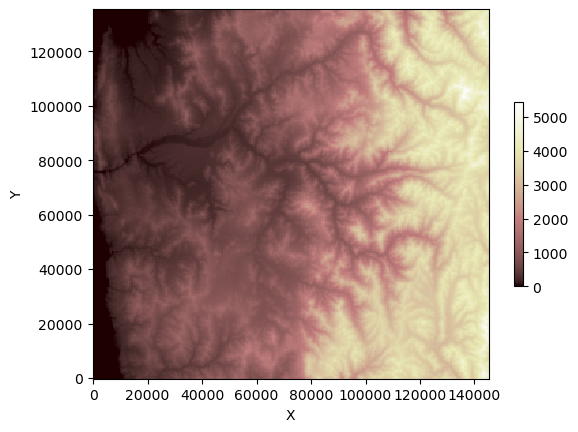

In [7]:
# create a dataset of zero values
zr = mg.add_zeros("topographic__elevation", at="node")

# apply cell elevation to defined arrray
zr += elevArray[::-1,:].ravel()
print(zr)
imshow_grid(mg, "topographic__elevation", shrink=0.5)

In [28]:
#set and apply and initial height
initialHeight = 0.25
depthArray = np.ones(elevArray.shape)*initialHeight
mg.at_node["surface_water__depth"] = depthArray

In [29]:
#define the flood objeds
of = OverlandFlow(mg, steep_slopes=True, rainfall_intensity=0.030/3600/24)

#list to store times
dtList = []

In [30]:
#Run once and store elapsed time
of.run_one_step()
dtList.append(of.dt)
print(of.dt)

223.572587199


In [31]:
# explore the output data and location

# model outputs
print(of.output_var_names)

# where this nodes are locates
print(of.var_loc("surface_water__depth"))

# show the water depth array
print(mg.at_node["surface_water__depth"])


('surface_water__depth', 'surface_water__discharge', 'water_surface__gradient')
node
[ 0.25001  0.25001  0.25001 ...,  0.25001  0.25001  0.25001]


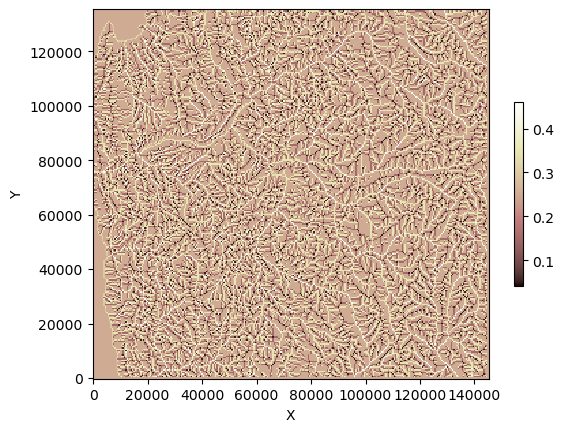

In [32]:
# plot the resulting water depth for the first run
imshow_grid(mg, "surface_water__depth", shrink=0.5)

In [33]:
# run the model for 100 time steps
for i in range(100):
    of.run_one_step()
    dtList.append(of.dt)
    print("Time step: %.2f seconds. Elapsed time %.2f seconds"%(of.dt,sum(dtList)))

Time step: 164.54 seconds. Elapsed time 388.11 seconds
Time step: 130.75 seconds. Elapsed time 518.87 seconds
Time step: 107.68 seconds. Elapsed time 626.55 seconds
Time step: 91.78 seconds. Elapsed time 718.33 seconds
Time step: 80.34 seconds. Elapsed time 798.67 seconds
Time step: 71.76 seconds. Elapsed time 870.43 seconds
Time step: 64.90 seconds. Elapsed time 935.33 seconds
Time step: 59.97 seconds. Elapsed time 995.30 seconds
Time step: 56.01 seconds. Elapsed time 1051.31 seconds
Time step: 52.81 seconds. Elapsed time 1104.12 seconds
Time step: 50.19 seconds. Elapsed time 1154.30 seconds
Time step: 48.00 seconds. Elapsed time 1202.30 seconds
Time step: 46.39 seconds. Elapsed time 1248.69 seconds
Time step: 45.21 seconds. Elapsed time 1293.90 seconds
Time step: 43.75 seconds. Elapsed time 1337.66 seconds
Time step: 42.27 seconds. Elapsed time 1379.93 seconds
Time step: 40.81 seconds. Elapsed time 1420.74 seconds
Time step: 39.37 seconds. Elapsed time 1460.11 seconds
Time step: 38.0

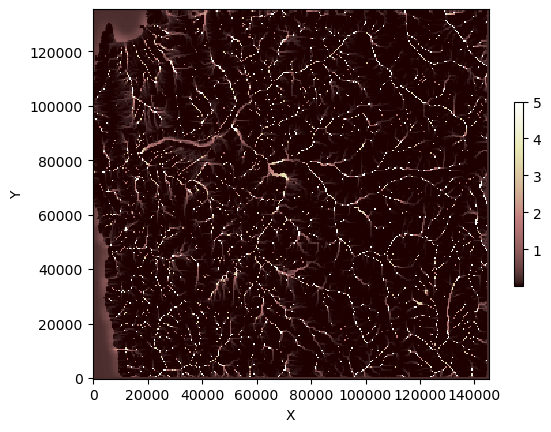

In [34]:
# plot the resulting water depth for the 101th run
imshow_grid(mg, "surface_water__depth", shrink=0.5,vmax=5)

In [35]:
#convert the resulting data to a numpy array
zArray = mg.at_node["surface_water__depth"].reshape((nrows,ncols))[::-1,:]
print(zArray)

[[  2.50010000e-01   2.50010000e-01   2.50010000e-01 ...,   2.50010000e-01
    2.50010000e-01   2.50010000e-01]
 [  2.50010000e-01   2.50343463e-01   2.50564902e-01 ...,   9.49603536e-05
    1.32677227e-03   2.50010000e-01]
 [  2.50010000e-01   2.50581780e-01   2.51026331e-01 ...,   1.90654679e-03
    1.00000000e-08   2.50010000e-01]
 ..., 
 [  2.50010000e-01   2.50226632e-01   2.50331327e-01 ...,   1.35542451e-02
    1.99934938e-01   2.50010000e-01]
 [  2.50010000e-01   2.50184431e-01   2.50254430e-01 ...,   1.00160980e-03
    2.20396931e-01   2.50010000e-01]
 [  2.50010000e-01   2.50010000e-01   2.50010000e-01 ...,   2.50010000e-01
    2.50010000e-01   2.50010000e-01]]


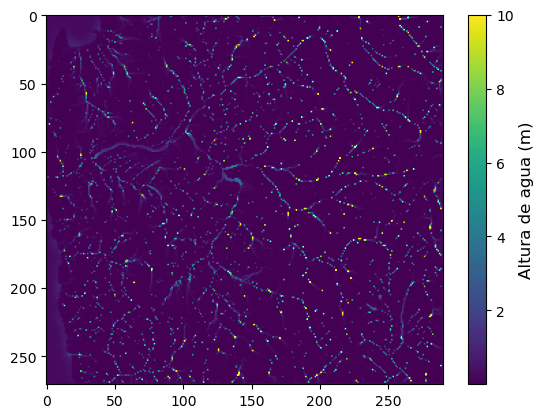

In [37]:
import matplotlib.pyplot as plt

# Plot the array
fig, ax = plt.subplots()
cax = ax.imshow(zArray, vmax=10)

# Add a colorbar with a label
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Altura de agua (m)', size=12)

plt.show()

In [22]:
# Write the array to a new GeoTIFF file
with rasterio.open(
        '../Out/floodSurfaceDepth.tif',
        'w',
        driver='GTiff',
        height=rasterObj.height,
        width=rasterObj.width,
        count=1,  # number of bands
        dtype=zArray.dtype,
        crs=rasterObj.crs,
        transform=rasterObj.transform
) as dst:
    dst.write(zArray, 1)  # write the data to the first band

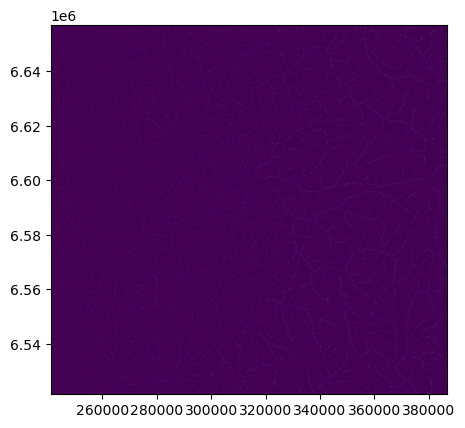

<Axes: >

In [33]:
# Show the resulting raster
floodObj = rasterio.open('../Out/floodSurfaceDepth.tif')
show(floodObj)